# Ad Hoh в Skytaxi


In [101]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

import warnings
warnings.filterwarnings('ignore')

## Задание 1
Постройте график с количеством заказов по суточным часам (на оси Х — часы от 0 до 23). <br>
 На сколько за один час в среднем делается больше заказов в часы пик, чем в обычное время? (По всем городам вмест. <br>
Рассмотрите города по отдельности: для каждого города выведите разницу в количестве заказов (среднечасовом) между часами пик и обычными часами. <br> В каком городе наблюдается наибольшее отклонение конверсии Order2Ride в часы пик по сравнению с обычными часами?)

In [103]:
# Чтение и первичный анализ данных

In [104]:
DS = pd.read_csv('Data_Skytaxi.csv', sep=';')
df_city = pd.read_csv('city_dict.csv', sep=';')
df_tariff = pd.read_csv('tariff_dict.csv', sep=';')

In [105]:
DS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10020 entries, 0 to 10019
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   order_id          10020 non-null  int64 
 1   id_tariff         10020 non-null  int64 
 2   id_city           10020 non-null  int64 
 3   order_time        10020 non-null  object
 4   assign_time       6743 non-null   object
 5   arrive_time       5345 non-null   object
 6   ride_finish_time  4834 non-null   object
dtypes: int64(3), object(4)
memory usage: 548.1+ KB


In [106]:
df_city.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id_city    9 non-null      int64 
 1   name_city  9 non-null      object
dtypes: int64(1), object(1)
memory usage: 276.0+ bytes


In [107]:
df_tariff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id_tariff    5 non-null      int64 
 1   name_tariff  5 non-null      object
dtypes: int64(1), object(1)
memory usage: 212.0+ bytes


In [108]:
# Объединяем таблицы 
DS = DS.merge(df_city, on = 'id_city')
DS = DS.merge(df_tariff, on = 'id_tariff')

In [109]:
# Переводим даты к нужному формату
for i in ['order_time', 'assign_time', 'arrive_time', 'ride_finish_time']:
    DS[i] = DS[i].apply(pd.to_datetime)

In [110]:
# Добавляем в таблицу столбец с часами пик
DS['hour'] = DS['order_time'].dt.hour
DS['peak'] = np.where(DS['hour'].isin([7, 8, 9, 10, 17, 18, 19, 20]), 1, 0)

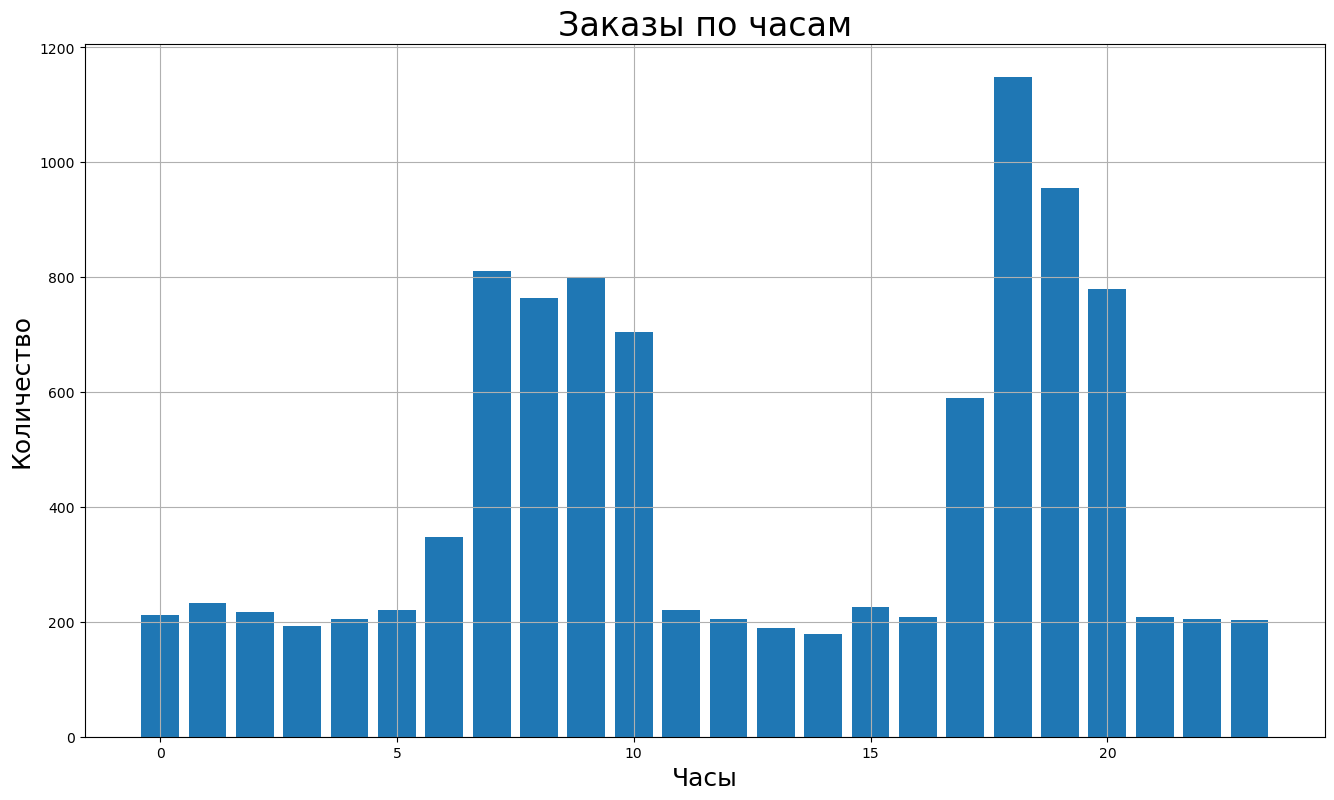

In [197]:
# Визуализируем кол-во заказов по часам 
DS_graph = DS.groupby(['hour']).count()['order_time'].reset_index()

plt.figure(figsize=(16, 9))
plt.grid()
plt.title('Заказы по часам', size='24')
plt.xlabel('Часы', size='18')
plt.ylabel('Количество', size='18')
plt.bar(DS_graph['hour'], DS_graph['order_time'])
plt.show()

In [112]:
# Группируем кол-во заказов по часу пик
# А так же кол-во заказов по городу и часу пик
DS_gr = DS.groupby(['peak']).count()[['order_time']].reset_index()
DS_gr_city = DS.groupby(['peak', 'name_city']).count()[['order_time']].reset_index()

In [113]:
# Считаем среднее кол-во заказов обычных и в часы пик
DS_gr['orders_by_hour'] = np.where(DS_gr['peak'] == 0, DS_gr['order_time'] / 16, DS_gr['order_time'] / 8)
DS_gr_city['orders_by_hour'] = np.where(DS_gr_city['peak'] == 0, DS_gr_city['order_time'] / 16, DS_gr_city['order_time'] / 8)

In [114]:
# Считаем разницу между часами пик и обычными по кол-ву заказов в среднем 
Diff_cnt = DS_gr[(DS_gr['peak'] == 1)]['orders_by_hour'].item() - DS_gr[(DS_gr['peak'] == 0)]['orders_by_hour'].item()
print('Разница по среднему кол-ву заказов на один час между обычными часами и часами пик', Diff_cnt)

Разница по среднему кол-ву заказов на один час между обычными часами и часами пик 602.4375


In [115]:
# Создаем таблицу с городами
DS_cities = pd.DataFrame({'city': DS_gr_city['name_city'].unique()})

In [116]:
# Пишем функцию считающую разницу среднего кол-ва заказов в часы пик и обычными
def diff(i):
    return DS_gr_city[(DS_gr_city['peak'] == 1) & (DS_gr_city['name_city'] == i)]['orders_by_hour'].item() \
          - DS_gr_city[(DS_gr_city['peak'] == 0) & (DS_gr_city['name_city'] == i)]['orders_by_hour'].item()

In [117]:
DS_cities['diff_hour'] = DS_cities['city'].map(diff)

In [118]:
DS_cities.style.background_gradient(cmap='Blues', axis=0, subset=['diff_hour'])

,city,diff_hour
0,Екатеринбург,35.437500
1,Казань,56.937500
2,Краснодар,46.937500
3,Красноярск,30.625000
4,Москва,182.812500
5,Новосибирск,54.500000
6,Санкт-Петербург,119.750000
7,Тюмень,36.625000
8,Хабаровск,38.812500


In [119]:
# Группируем таблицу, и считаем конверсию от заказа к завершению поездки
df_o2r = DS.groupby(['peak', 'name_city']).count()[['order_time', 'ride_finish_time']].reset_index()
df_o2r['o2r'] = df_o2r['ride_finish_time'] / df_o2r['order_time']

In [120]:
# Пишем функцию считающую разницу конверсии между заказами обычными и часами пик
def diff_conv(i):
    return abs(df_o2r[(df_o2r['peak'] == 1) & (df_o2r['name_city'] == i)]['o2r'].item() \
          - df_o2r[(df_o2r['peak'] == 0) & (df_o2r['name_city'] == i)]['o2r'].item())

In [121]:
DS_cities['diff_conver'] = DS_cities['city'].map(diff_conv)

In [122]:
# Подсвечиваем наибольшую разницу в конверсии
DS_cities.set_index('city') \
     .style.format('{:.3f}')\
     .background_gradient(cmap='Reds', axis=0, subset=['diff_hour'])\
     .highlight_max(color='red', axis=0, subset=['diff_conver'])

,diff_hour,diff_conver
city,,
Екатеринбург,35.438,0.007
Казань,56.938,0.025
Краснодар,46.938,0.035
Красноярск,30.625,0.059
Москва,182.812,0.117
Новосибирск,54.500,0.021
Санкт-Петербург,119.750,0.093
Тюмень,36.625,0.004
Хабаровск,38.812,0.064


## Задание 2
Изучите заказы в Хабаровске и Тюмени. Эти города интересуют менеджеров, так как в них наша компания начала работать относительно недавно. <br>
 На сколько процентных пунктов Order2Ride в среднем в них ниже, чем в других города <br> 

 За счет какого звена воронки достигается эта разница? Сделайте выводы по Хабаровску и по Тюмени по отдельности.

In [124]:
# Отмечаем нужные города
DS['new_city'] = np.where(DS['name_city'].isin(['Тюмень', 'Хабаровск']), DS['name_city'], 'Other')

In [125]:
# Группируем по ним кол-во заказов
df_gr = DS.groupby('new_city').count()[['order_time', 'assign_time', 'arrive_time', 'ride_finish_time']].reset_index()

In [126]:
# Создаем столбцы с цепочкой конверсий заказов 
df_gr['o2ass'] = df_gr['assign_time']      / df_gr['order_time'] # Звено конверсии от заказа к назначению водителя
df_gr['ass2arr'] = df_gr['arrive_time']      / df_gr['assign_time'] # Звено конверсии от назначения к прибытию
df_gr['arr2r'] = df_gr['ride_finish_time'] / df_gr['arrive_time'] # Звено конверсии от прибытия к завершению поезки 
df_gr['o2r']  = df_gr['ride_finish_time'] / df_gr['order_time'] # Общая конверсия от заказа к завершению поездки

In [127]:
#Считаем разницу в конверсии между новыми городами и остальными
Tum = round((df_gr[df_gr['new_city'] == 'Other']['o2r'].item() - df_gr[df_gr['new_city'] == 'Тюмень']['o2r'].item()) * 100, 2)
Hab = round((df_gr[df_gr['new_city'] == 'Other']['o2r'].item() - df_gr[df_gr['new_city'] == 'Хабаровск']['o2r'].item()) * 100, 2)

In [128]:
print('Падение конверсии из заказа в поездку по отношению к другим городам', '\n',
        'В Тюмене - ', Tum, '%', '\n',
        'В Хабаровке -', Hab, '%')

Падение конверсии из заказа в поездку по отношению к другим городам 
 В Тюмене -  24.62 % 
 В Хабаровке - 25.08 %


In [129]:
#выделим какие звенья в цепочке просидают
df_gr[['new_city','o2ass','ass2arr','arr2r','o2r']].set_index('new_city') \
    .style.format('{:.2f}')\
    .highlight_min(color='red', axis=0, subset=['o2ass','ass2arr','arr2r','o2r'])

,o2ass,ass2arr,arr2r,o2r
new_city,,,,
Other,0.70,0.79,0.92,0.51
Тюмень,0.56,0.84,0.57,0.27
Хабаровск,0.34,0.81,0.95,0.26


В Тюмене очень сильное падение в последнем звене воронки, что то вынуждает клиентов часто отменять заказ после прибытия водителя. <br>
В Хабаровске значительное падение в первом звене, мало назначений водителя. Скорее всего недостаточно машин.

## Задание 3
К вам обратились коллеги из отдела антифрода (отдела, предотвращающего мошенничество). У них есть подозрение, что некоторые водители мимикрируют координаты, то есть на самом деле не приезжают в точку А своего заказа, но в приложение посылают сигнал, что они в эту точку А приехали. Таким образом они вынуждают клиента отменить заказ после «прибытия ими в точку А». <br>
Постарайтесь локализовать данную проблему и выделить города, в которых такое происходит чаще всего.

In [132]:
# Группируем по городам кол-во заказаов только в последнем звене нашей воронки, конверсию от прибытия машины в поездку 
df_gr2 = DS.groupby(['name_city']).count()[['arrive_time', 'ride_finish_time']].reset_index()

In [133]:
# Считаем конверсию
df_gr2['arr2r'] = df_gr2['ride_finish_time'] / df_gr2['arrive_time']

In [134]:
# И смотрим в каких городах данное звено просидает
df_gr2.style.background_gradient(cmap='Blues', axis=0, subset='arr2r')

,name_city,arrive_time,ride_finish_time,arr2r
0,Екатеринбург,354,333,0.940678
1,Казань,528,506,0.958333
2,Краснодар,457,428,0.936543
3,Красноярск,320,195,0.609375
4,Москва,1594,1505,0.944166
5,Новосибирск,525,501,0.954286
6,Санкт-Петербург,1099,1033,0.939945
7,Тюмень,295,169,0.572881
8,Хабаровск,173,164,0.947977


Видим значительное падение на данном звене в городах Краснорярск и Тюмень.
В этих городах водители чаще всего мошенничают с координатами прибытия в точку А.

## Задание 4
Тариф «Доставка» был запущен недавно по всей России. 
Изучите конверсии в рамках данного тарифа по городам, локализуйте просадку конверсии Order2Ride в рамках данного тарифа и дайте рекомендации отделу операционистов, которые занимаются этим тарифом.

In [137]:
DS.head()

,order_id,id_tariff,id_city,order_time,assign_time,arrive_time,ride_finish_time,name_city,name_tariff,hour,peak,new_city
0,1146020,111,13,2022-04-08 07:12:00,NaT,NaT,NaT,Казань,Эконом,7,1,Other
1,1146340,114,11,2022-02-08 19:12:00,2022-02-08 19:19:00,2022-02-08 19:26:00,2022-02-08 19:50:00,Москва,Бизнес,19,1,Other
2,1142747,112,13,2022-01-08 13:47:00,2022-01-08 13:53:00,2022-01-08 13:59:00,2022-01-08 14:16:00,Казань,Комфорт,13,0,Other
3,1137227,111,17,2022-03-08 15:45:00,NaT,NaT,NaT,Тюмень,Эконом,15,0,Тюмень
4,1137156,111,13,2022-02-08 15:00:00,2022-02-08 15:02:00,2022-02-08 15:11:00,2022-02-08 15:26:00,Казань,Эконом,15,0,Other


In [138]:
#Создаем таблицу только с тарифом "Доставка"
df_de = DS[DS['name_tariff'] == 'Доставка']

In [139]:
#Смотрим на доли кол-ва наблюдений по городам
df_de['name_city'].value_counts(normalize=True)

name_city
Москва             0.335878
Санкт-Петербург    0.209160
Новосибирск        0.099237
Казань             0.083969
Екатеринбург       0.071756
Хабаровск          0.071756
Тюмень             0.067176
Красноярск         0.058015
Краснодар          0.003053
Name: proportion, dtype: float64

In [140]:
#Удаляем Краснодар, как город с недостаточным кол-вом наблюдений
df_de = df_de[df_de['name_city'] != 'Краснодар']

In [141]:
df_de.head()

,order_id,id_tariff,id_city,order_time,assign_time,arrive_time,ride_finish_time,name_city,name_tariff,hour,peak,new_city
16,1143951,115,16,2022-02-08 14:55:00,2022-02-08 14:58:00,2022-02-08 15:23:00,NaT,Красноярск,Доставка,14,0,Other
40,1139554,115,12,2022-06-08 00:14:00,2022-06-08 00:19:00,2022-06-08 00:36:00,2022-06-08 00:54:00,Санкт-Петербург,Доставка,0,0,Other
43,1139537,115,11,2022-05-08 20:38:00,2022-05-08 20:42:00,2022-05-08 20:59:00,2022-05-08 21:22:00,Москва,Доставка,20,1,Other
62,1145302,115,11,2022-07-08 08:15:00,2022-07-08 08:18:00,2022-07-08 08:39:00,2022-07-08 09:00:00,Москва,Доставка,8,1,Other
75,1146168,115,12,2022-04-08 06:23:00,2022-04-08 06:27:00,2022-04-08 06:45:00,2022-04-08 07:06:00,Санкт-Петербург,Доставка,6,0,Other


In [142]:
# Группируем по городам звенья воронки

df_de_gr = df_de.groupby('name_city').count()[['order_time','assign_time','arrive_time','ride_finish_time']].reset_index()

# И создаем столбцы с цепочкой конверсий заказов
df_de_gr['o2ass']       = df_de_gr['assign_time']      / df_de_gr['order_time']
df_de_gr['ass2arr']     = df_de_gr['arrive_time']      / df_de_gr['assign_time']
df_de_gr['arr2r']       = df_de_gr['ride_finish_time'] / df_de_gr['arrive_time']
df_de_gr['o2r']         = df_de_gr['ride_finish_time'] / df_de_gr['order_time']

In [143]:
# Создаем нижний и верхний показатель доверительного интервала ( 95% ) для конверсий
df_de_gr['o2r_upper']     = df_de_gr['o2r'] + 1.96 * (df_de_gr['o2r'] * (1 - df_de_gr['o2r']) / df_de_gr['order_time']).apply(np.sqrt)
df_de_gr['o2r_lower']     = df_de_gr['o2r'] - 1.96 * (df_de_gr['o2r'] * (1 - df_de_gr['o2r']) / df_de_gr['order_time']).apply(np.sqrt)

df_de_gr['o2ass_upper']   = df_de_gr['o2ass'] + 1.96 * (df_de_gr['o2ass'] * (1 - df_de_gr['o2ass']) / df_de_gr['order_time']).apply(np.sqrt)
df_de_gr['o2ass_lower']   = df_de_gr['o2ass'] - 1.96 * (df_de_gr['o2ass'] * (1 - df_de_gr['o2ass']) / df_de_gr['order_time']).apply(np.sqrt)

df_de_gr['ass2arr_upper'] = df_de_gr['ass2arr'] + 1.96 * (df_de_gr['ass2arr'] * (1 - df_de_gr['ass2arr']) / df_de_gr['assign_time']).apply(np.sqrt)
df_de_gr['ass2arr_lower'] = df_de_gr['ass2arr'] - 1.96 * (df_de_gr['ass2arr'] * (1 - df_de_gr['ass2arr']) / df_de_gr['assign_time']).apply(np.sqrt)

df_de_gr['arr2r_upper']   = df_de_gr['arr2r'] + 1.96 * (df_de_gr['arr2r'] * (1 - df_de_gr['arr2r']) / df_de_gr['arrive_time']).apply(np.sqrt)
df_de_gr['arr2r_lower']   = df_de_gr['arr2r'] - 1.96 * (df_de_gr['arr2r'] * (1 - df_de_gr['arr2r']) / df_de_gr['arrive_time']).apply(np.sqrt)

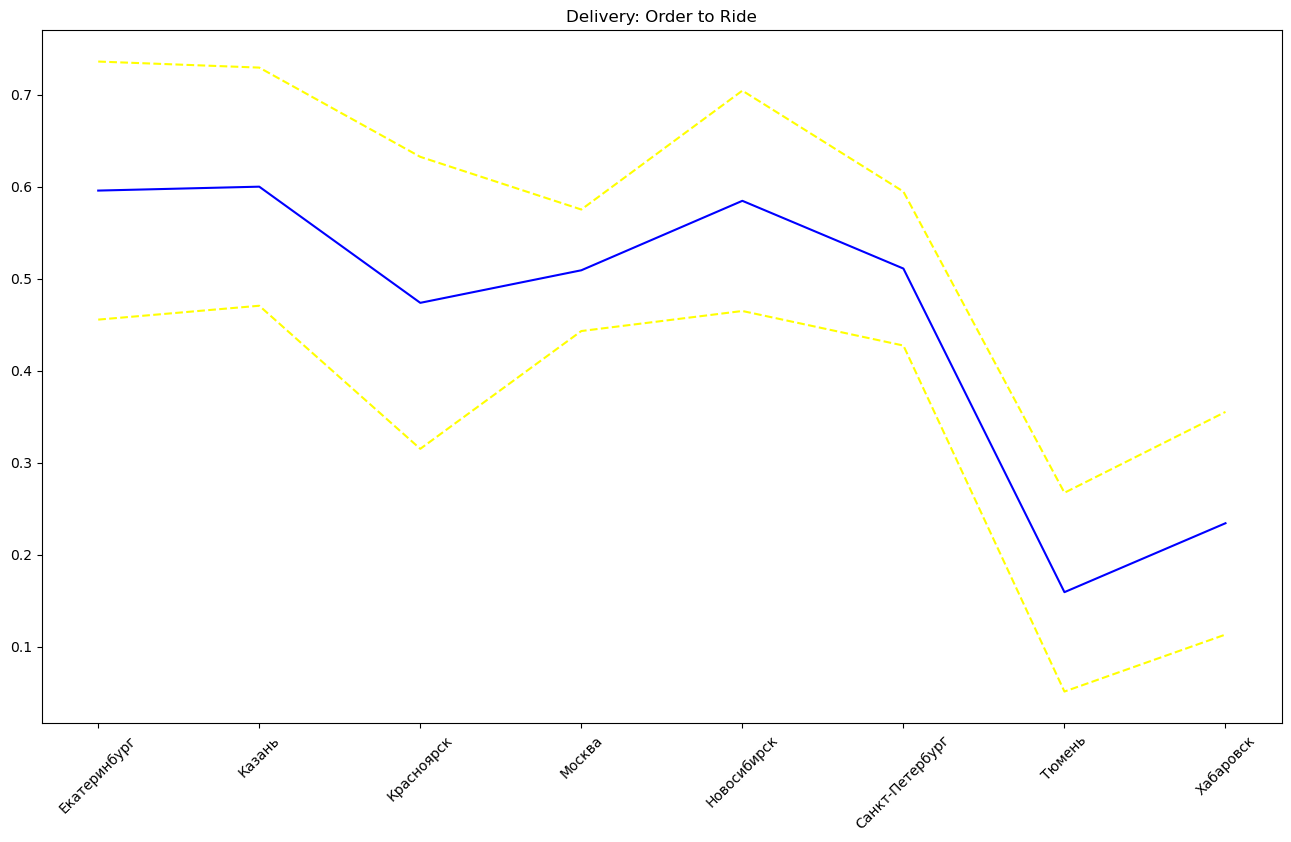

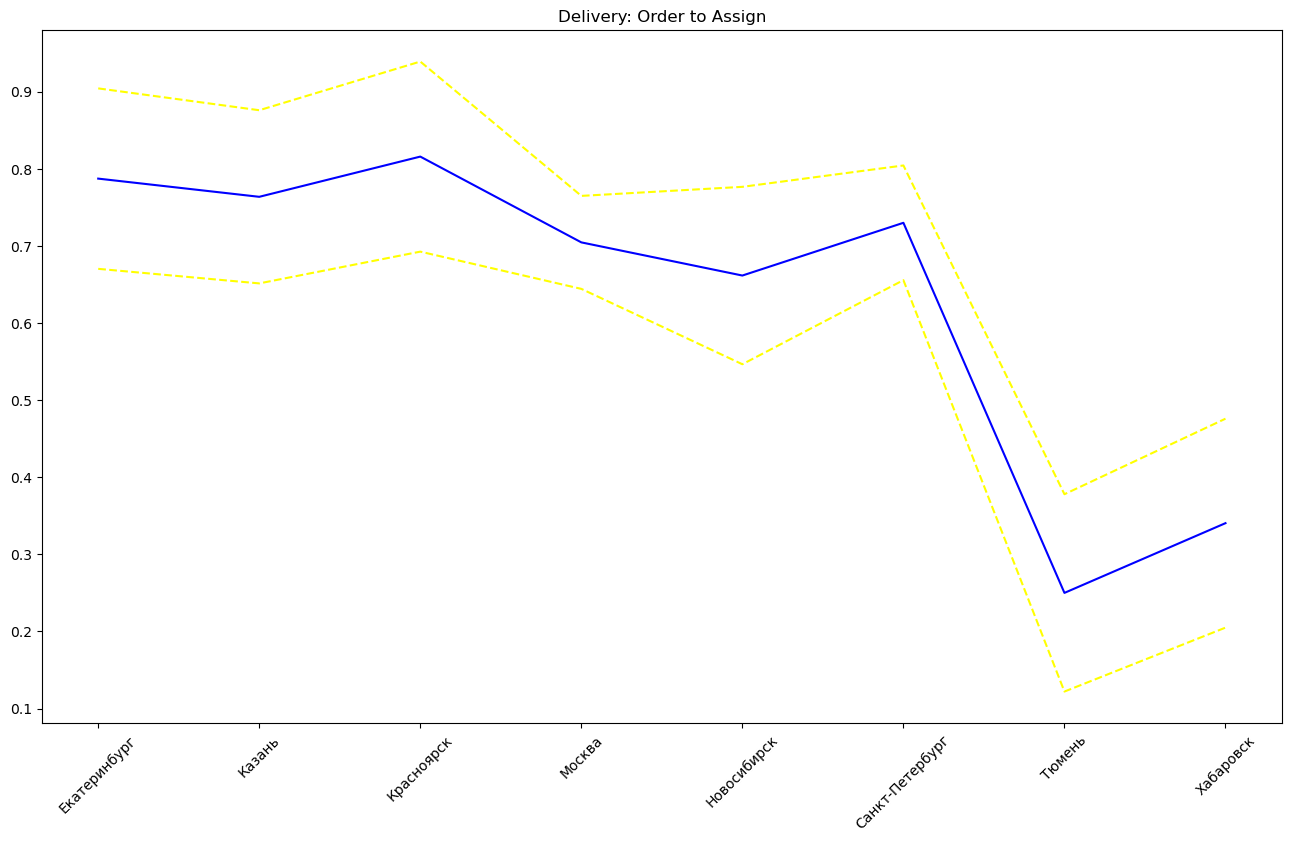

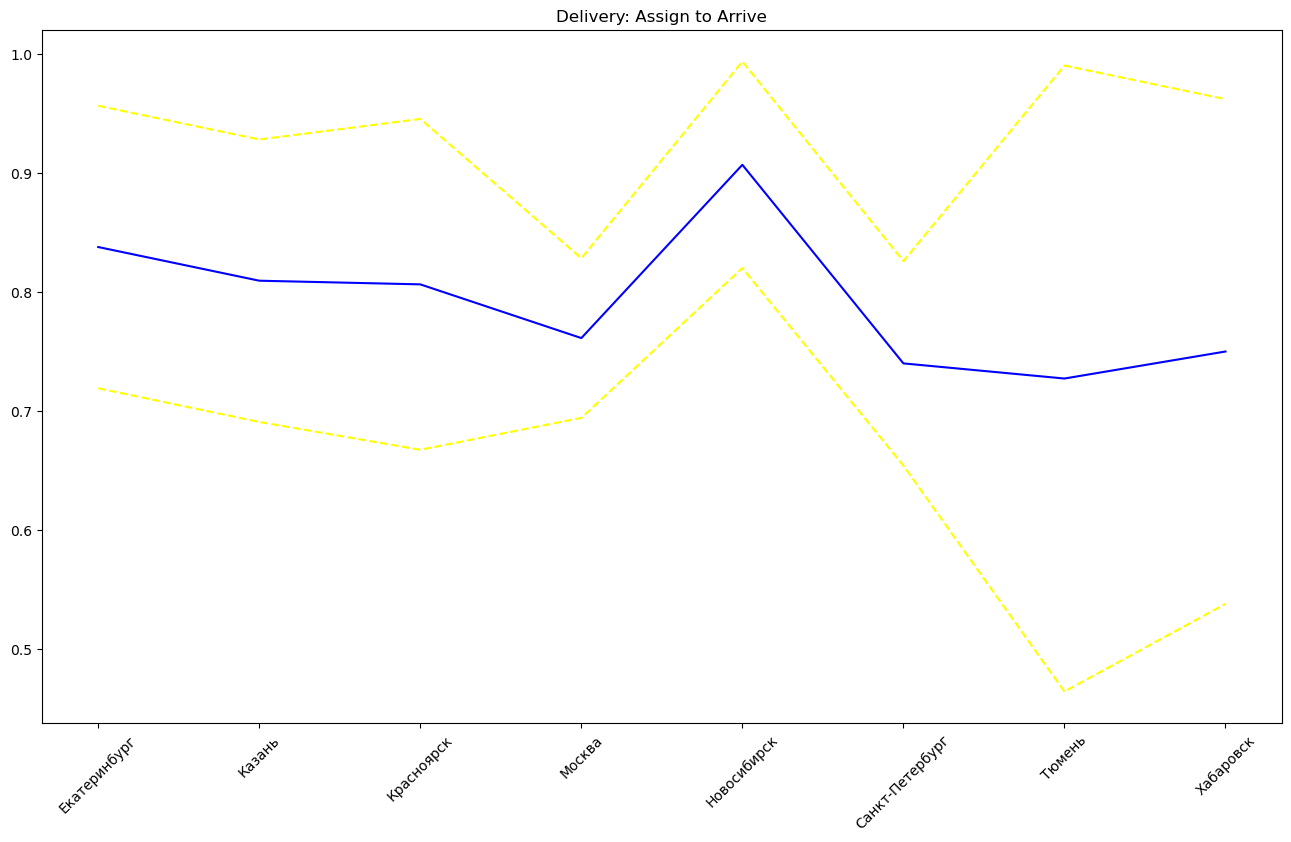

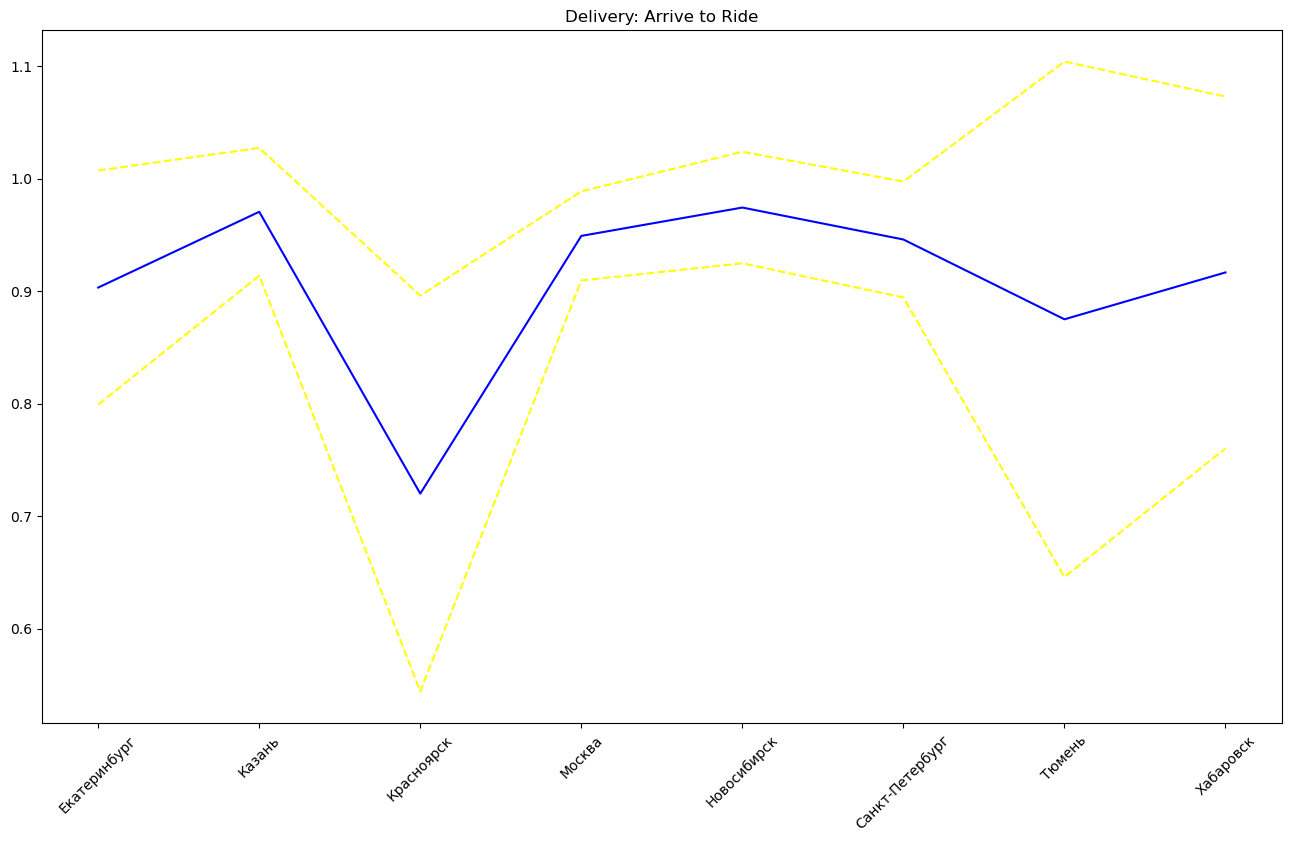

In [144]:
# Визуализируем Order to Ride и другие звенья конверсии по городам вместе с доверительными интервалами
plt.figure()
plt.rcParams["figure.figsize"] = (16,9)

steps = {'o2r': 'Order to Ride', 'o2ass':'Order to Assign', 'ass2arr':'Assign to Arrive', 'arr2r':'Arrive to Ride'}
for col in steps.keys():
    plt.plot(df_de_gr['name_city'], df_de_gr[col], color = 'blue')
    plt.plot(df_de_gr['name_city'], df_de_gr[f'{col}_upper'], color = 'yellow', linestyle='--')
    plt.plot(df_de_gr['name_city'], df_de_gr[f'{col}_lower'], color = 'yellow', linestyle='--')
    plt.xticks(rotation=45)
    plt.title(f'Delivery: {steps[col]}')
    plt.show()

In [145]:
# Для сравнения с другими тарифами создадим доп. столбец.
DS['tariff'] = np.where(DS['name_tariff'].isin(['Доставка']), DS['name_tariff'], 'Other')

In [146]:
# Удалим города с недостаточным кол-вом данных 
df_trf = DS[~DS['name_city'].isin(['Краснодар'])]

In [147]:
# Группируем звенья воронки по городам и тарифам  
df_trf_gr = df_trf.groupby(['name_city', 'tariff']).count()[['order_time', 'assign_time','arrive_time', 'ride_finish_time']].reset_index()

In [148]:
# И создаем столбцы с цепочкой конверсий заказов
df_trf_gr['o2r']      = df_trf_gr['ride_finish_time'] / df_trf_gr['order_time']
df_trf_gr['o2ass']    = df_trf_gr['assign_time']      / df_trf_gr['order_time']
df_trf_gr['ass2arr']  = df_trf_gr['arrive_time']      / df_trf_gr['assign_time']
df_trf_gr['arr2r']    = df_trf_gr['ride_finish_time'] / df_trf_gr['arrive_time']

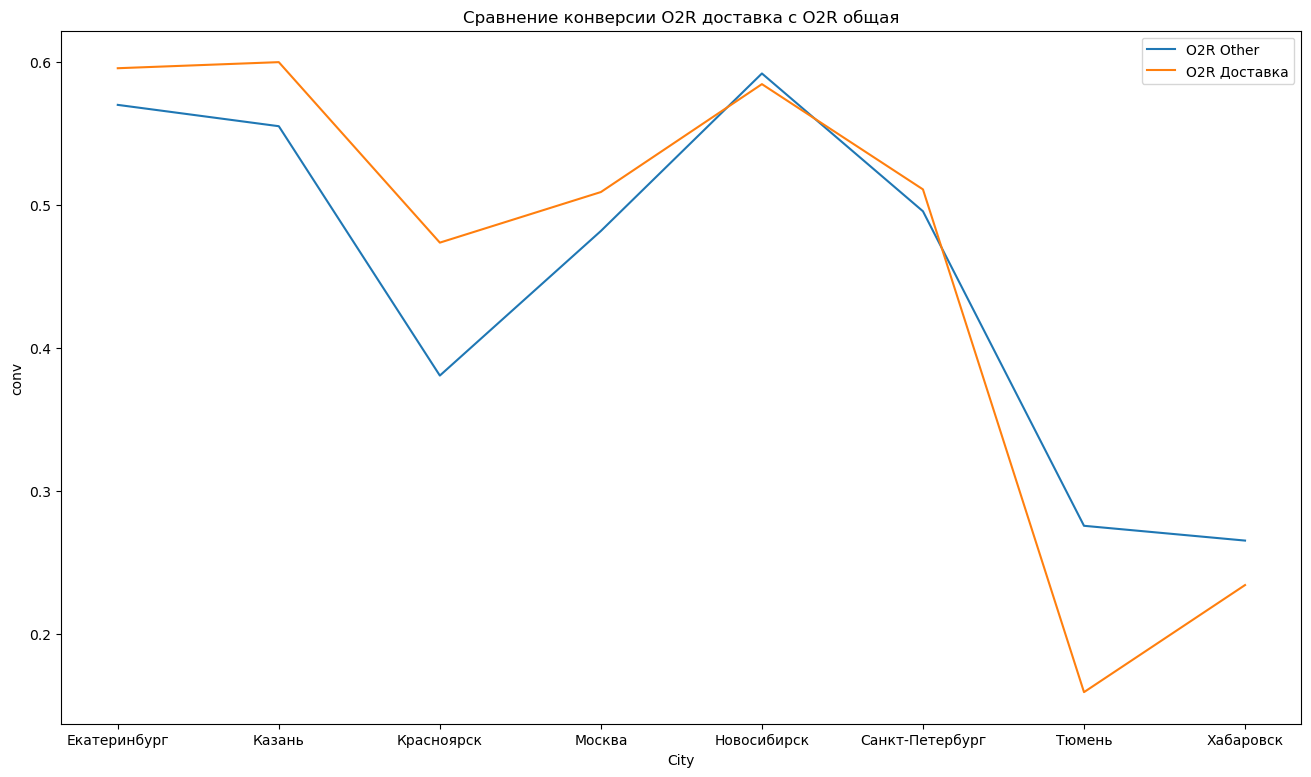

In [149]:
#Визуализируем Order to Ride Доставки и Общий  
plt.figure(figsize=(16, 9))  
plt.title('Сравнение конверсии O2R доставка с O2R общая')  
plt.xlabel('City') 
plt.ylabel('conv') 

for i in df_trf_gr['tariff'].unique():
    
    plt.plot(df_trf_gr[df_trf_gr['tariff'] == i]['name_city'], df_trf_gr[df_trf_gr['tariff'] == i]['o2r'], label = f'O2R {i}')

plt.legend()
plt.show()

В общем и целом видим что конверсия по тарифу "Доставка" ничем не отличается от других тарифов

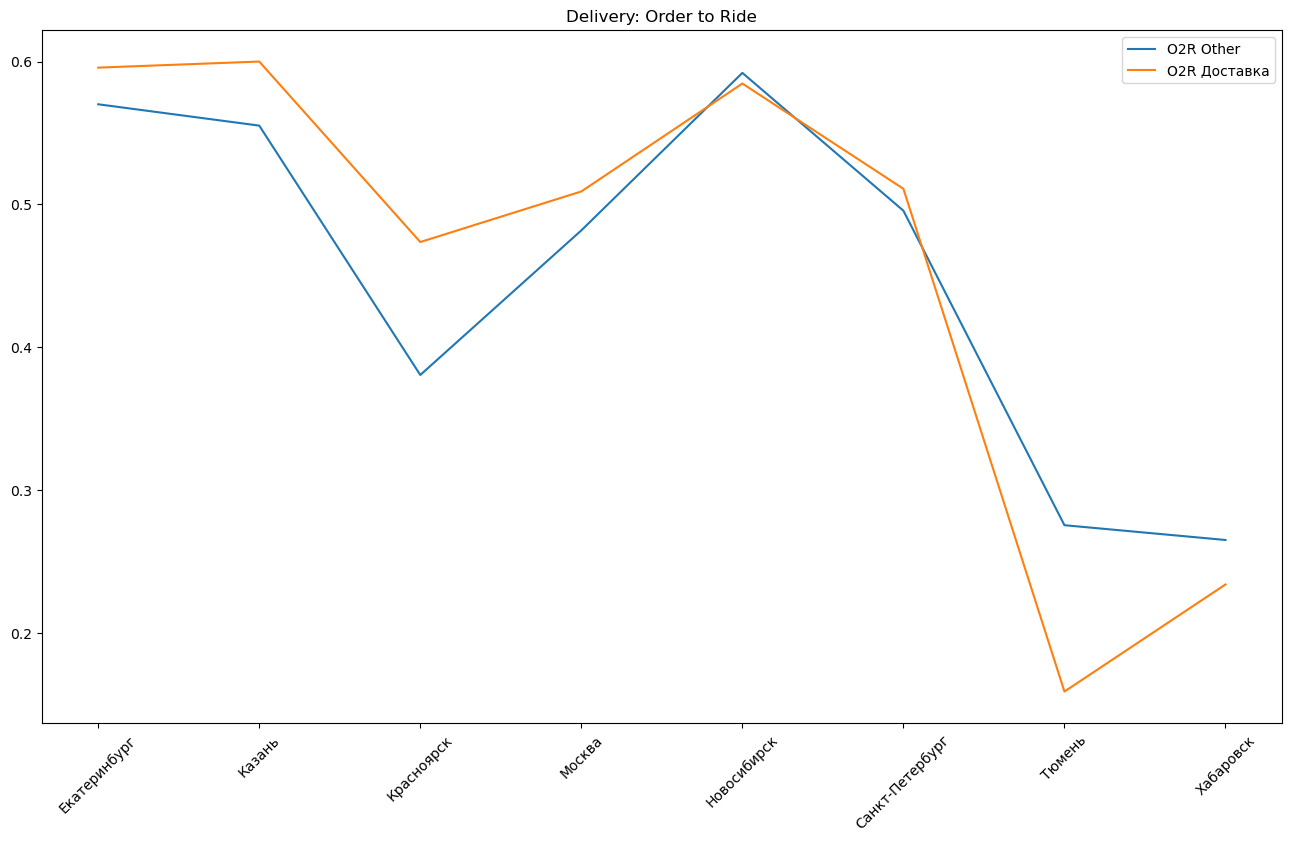

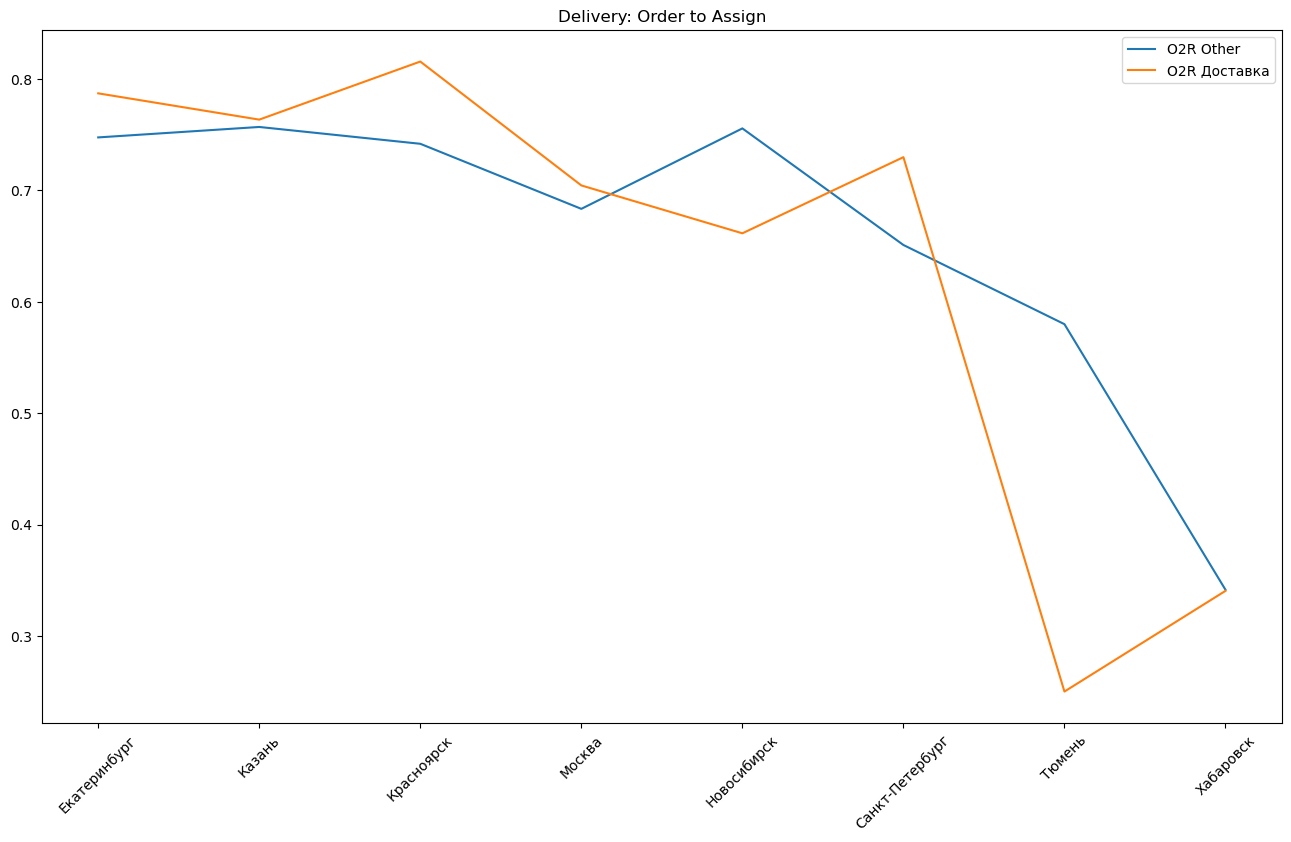

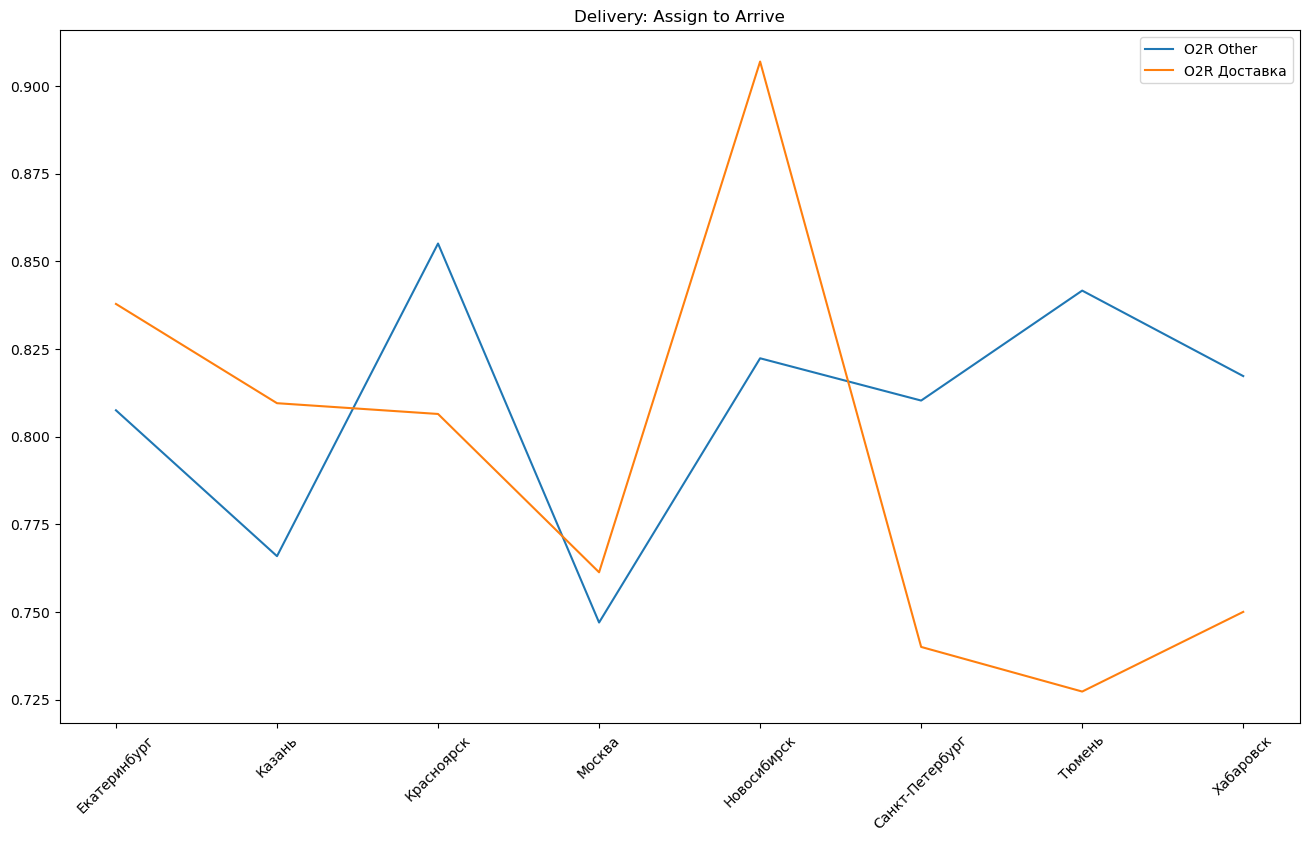

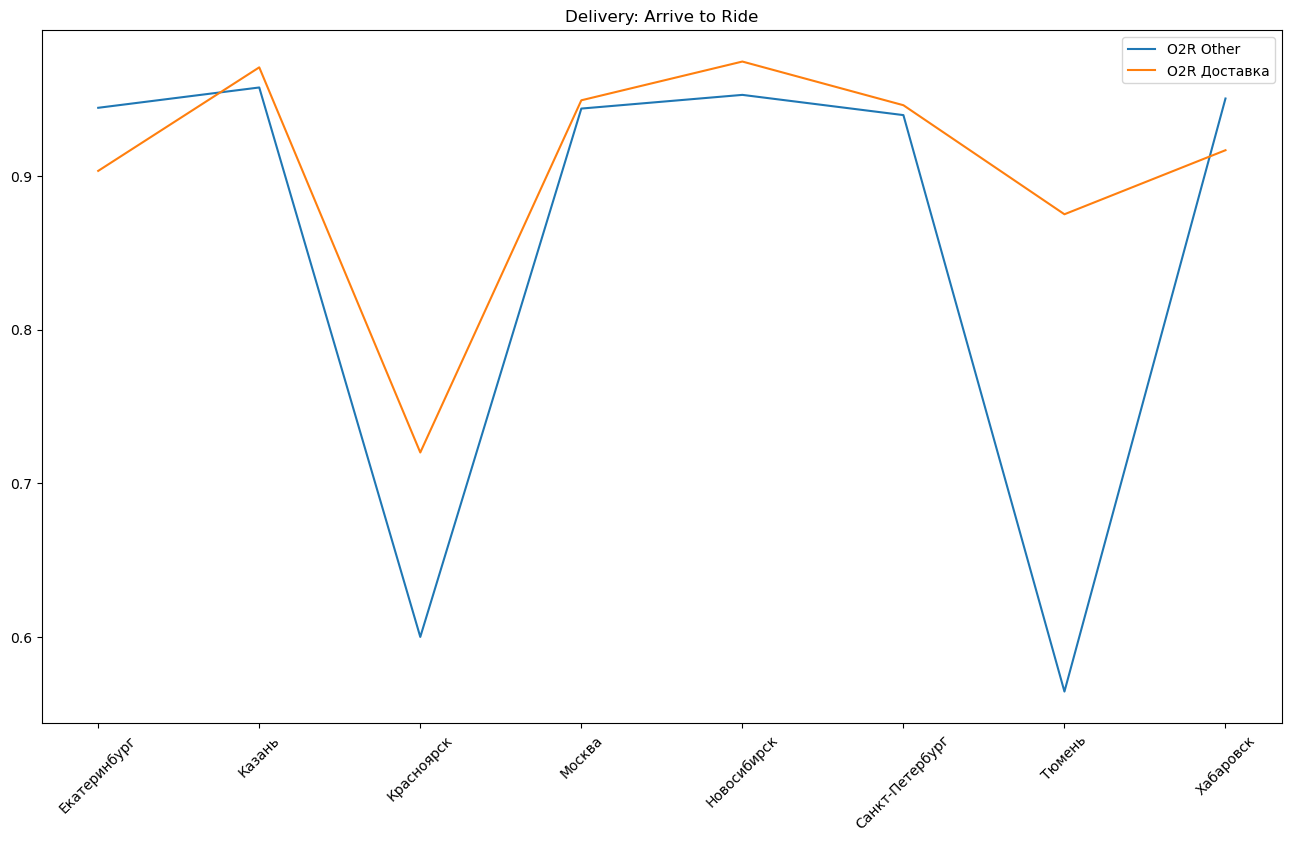

In [151]:
#Визуализируем сравнение тарифов по каждому звену конверсии отдельно
plt.figure()
plt.rcParams["figure.figsize"] = (16,9)

steps = {'o2r': 'Order to Ride', 'o2ass':'Order to Assign', 'ass2arr':'Assign to Arrive', 'arr2r':'Arrive to Ride'}
for col in steps.keys():
    for i in df_trf_gr['tariff'].unique():
        plt.plot(df_trf_gr[df_trf_gr['tariff'] == i]['name_city'], df_trf_gr[df_trf_gr['tariff'] == i][col], label = f'O2R {i}')
    
    
    plt.xticks(rotation=45)
    plt.legend()
    plt.title(f'Delivery: {steps[col]}')
    plt.show()

Отделу операционистов по "Доставке" стоит изучить видимую просадку в звене "От назчения водителя к его прибытию" по городам : Питер, Тюмень и Хабаровск.
Клиенты чаще отказыватся от назначенной машины.
В Тюмене так же нужно обратить внимание на просадку по назначению водителя, возможно нехватает водителей.